---
title: "24-双重差分(DID)"
subtitle: "双重差分模型与示例"
author: "Simon Zhou"
date: "2025-05-11"
format: 
    html:
        code-fold: false
        fig_caption: true
        number-sections: true
        toc: true
        toc-depth: 2
---

## 什么是 DID


双重差分回归 (DID) 用于评估一个事件的因果效应，其方法是比较事件发生的单元集合（处理组）与事件未发生的单元集合（控制组）。

DID 背后的逻辑是，如果事件从未发生，处理组和控制组之间的差异应该随着时间的推移保持不变。

DID 通过比较处理组和控制组在事件发生前后的差异来估计事件的因果效应。

DID 法是一种无法随机分配样本情况下的替代方法，主要应用于区域行的策略评估问题。

目标：获取相对同质的策略组和控制组，这个“相对”是指除策略影响外，策略组和控制组的结果变量随时间的变化存在一个基本固定的差异。

对于相对同质的策略组和控制组，DID法通过第一次的差分消除这个基本固定的差异，通过第二次的差分消除时间趋势的影响，评估策略带来的实际效应。

从DID 法的目标中可知，该方法面对的实验数据是面板数据（多个时间点的截面数据组成面板数据），即在策略干预时间点前，至少有两个时间点的数据。

$$
y = \alpha_0 +\alpha_1g +\alpha_2T + \alpha_3gT + \epsilon
$$
$\alpha_0$为常数项，$\alpha_1$为处理组和控制组的差异，$\alpha_2$为时间效应，$\epsilon$为误差项。
$\alpha_3$为交互项的系数，表示处理组和控制组在事件发生前后的差异。

其中，$y$为结果变量，$g$为处理组和控制组的虚拟变量，$T$为时间虚拟变量，$gT$为交互项。
$\alpha_3$为DID估计量，表示处理组和控制组在事件发生前后的差异。

DID 模型的有效性检验

为了保证该模型的有效性，在试验设计时需要满足平行趋势假设：在事件发生前，处理组和控制组的结果变量随时间的变化存在一个基本固定的差异。

平行趋势，即策略组和控制组在干预前保持相同的变化趋势。

3种常见的平行趋势的检验方法：

1. 画图法：画出处理组和控制组在事件发生前后的结果变量的变化趋势图，观察两组的变化趋势是否平行。
2. 统计检验法：使用t检验或F检验等统计方法，检验处理组和控制组在事件发生前的结果变量的差异是否显著。
3. 伪DID法：在事件发生前，随机选择一个时间点，将处理组和控制组的结果变量进行差分，检验差分后的结果变量是否显著。

In [2]:
import stata_setup
stata_setup.config('C:/Program Files/Stata18', 'mp', splash=False)

## 导入数据

使用 Princeton University 提供的示例程序与数据集，具体参见：[Differences‐in‐Differences (using Stata)](https://reformship.github.io/pages/1capacity/3program/Stata/Princeton/DID101.pdf)

In [5]:
%%stata
use "http://dss.princeton.edu/training/Panel101.dta", clear
* 查看数据随机十个数据
list in 1/10


. use "http://dss.princeton.edu/training/Panel101.dta", clear

. * 查看数据随机十个数据
. list in 1/10

     +------------------------------------------------------------------------+
  1. | country | year |          y | y_bin |       x1 |        x2 |        x3 |
     |       A | 1990 |  1.343e+09 |     1 | .2779036 | -1.107956 |  .2825536 |
     |------------------------------------------------------------------------|
     |                 opinion               |               op               |
     |               Str agree               |                1               |
     +------------------------------------------------------------------------+

     +------------------------------------------------------------------------+
  2. | country | year |          y | y_bin |       x1 |        x2 |        x3 |
     |       A | 1991 | -1.900e+09 |     0 | .3206847 |   -.94872 |  .4925385 |
     |------------------------------------------------------------------------|
     |                 o

## 创建变量

### 创建时间虚拟变量

创建一个虚拟变量来指示治疗开始的时间。假设治疗始于 1994 年。在这种情况下，1994 年之前的值为 0，1994 年之后的值为 1。如果您已经创建了虚拟变量，请跳过此步骤。

In [3]:
%%stata
gen time = (year>=1994) & !missing(year)

### 创建治疗虚拟变量

创建一个虚拟变量来标识接受治疗的组。在本例中，假设代码为 5、6 和 7 的国家/地区接受了治疗 (=1)。代码为 1-4 的国家/地区未接受治疗 (=0)。如果您已经创建了虚拟变量，请跳过此步骤。

In [4]:
%%stata
gen treated = (country>4) & !missing(country)

## 创建交互项

在时间和治疗之间创建交互。我们将此交互称为 "did"

In [5]:
%%stata
gen did = time*treated

## 估计 DID 估计量

In [6]:
%%stata
reg y time treated did, r


Linear regression                               Number of obs     =         70
                                                F(3, 66)          =       2.17
                                                Prob > F          =     0.0998
                                                R-squared         =     0.0827
                                                Root MSE          =     3.0e+09

------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
        time |   2.29e+09   9.00e+08     2.54   0.013     4.92e+08    4.09e+09
     treated |   1.78e+09   1.05e+09     1.70   0.094    -3.11e+08    3.86e+09
         did |  -2.52e+09   1.45e+09    -1.73   0.088    -5.42e+09    3.81e+08
       _cons |   3.58e+08   7.61e+08     0.47   0.640    -1.16e+09    1.88e+09
-------------

`did` 的系数是 双重差分 的估计量。效果在置信水准为 10% 时显著，且治疗措施产生了负面影响。

估计 DID 中的差分估计量（使用 `#` 方法，无需生成交互项）

In [7]:
%%stata
reg y time##treated, r


Linear regression                               Number of obs     =         70
                                                F(3, 66)          =       2.17
                                                Prob > F          =     0.0998
                                                R-squared         =     0.0827
                                                Root MSE          =     3.0e+09

------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
      1.time |   2.29e+09   9.00e+08     2.54   0.013     4.92e+08    4.09e+09
   1.treated |   1.78e+09   1.05e+09     1.70   0.094    -3.11e+08    3.86e+09
             |
time#treated |
        1 1  |  -2.52e+09   1.45e+09    -1.73   0.088    -5.42e+09    3.81e+08
             |
       _cons |   3.58e+08   7.61e+08     0.47  

变量 `time#treated` 的系数即为 DID 估计量（对应前述示例中的 `did` ）。该估计在10%的显著性水平下显著，显示处理措施产生了负向影响

## 使用 diff 命令

`diff` 由外部宏包提供，需要用户进行安装才可以使用：

In [8]:
%%stata
ssc install diff

checking diff consistency and verifying not already installed...
installing into C:\Users\asus\ado\plus\...
installation complete.


In [9]:
%%stata
diff y, t(treated) p(time)


DIFFERENCE-IN-DIFFERENCES ESTIMATION RESULTS
--------------------------------------------
Number of observations in the DIFF-IN-DIFF: 70
            Before         After    
   Control: 16             24          40
   Treated: 12             18          30
            28             42
--------------------------------------------------------
 Outcome var.   | y       | S. Err. |   |t|   |  P>|t|
----------------+---------+---------+---------+---------
Before          |         |         |         | 
   Control      |  3.6e+08|         |         | 
   Treated      |  2.1e+09|         |         | 
   Diff (T-C)   |  1.8e+09|  1.1e+09| 1.58    | 0.120
After           |         |         |         | 
   Control      |  2.6e+09|         |         | 
   Treated      |  1.9e+09|         |         | 
   Diff (T-C)   | -7.4e+08|  9.2e+08| 0.81    | 0.422
                |         |         |         | 
Diff-in-Diff    | -2.5e+09|  1.5e+09| 1.73    | 0.088*
------------------------------------

使用 `help diff` 查看更多的细节和选项。

## 双重差分

## 前后虚拟变量

### 创建一个指示变量

- 0 ：表示事件发生之前的时间
- 1 ：表示事件发生之时及其之后的时间

### 导入数据

In [11]:
%%stata
use "C:\Users\asus\Desktop\R\quarto\Med-Stat-Notes\Data\WDI.dta", clear

- 虚拟事件 X 在 2009 年发生，影响所有国家
- 构建一个事件前后虚拟变量：0 表示事件发生前，1 表示事件发生后

In [12]:
%%stata
gen after = (year >= 2009) if !missing(year)

### 检查数据类型

In [13]:
%%stata
tab year after


           |         after
      Time |         0          1 |     Total
-----------+----------------------+----------
      2000 |       126          0 |       126 
      2001 |       126          0 |       126 
      2002 |       126          0 |       126 
      2003 |       126          0 |       126 
      2004 |       126          0 |       126 
      2005 |       126          0 |       126 
      2006 |       126          0 |       126 
      2007 |       126          0 |       126 
      2008 |       126          0 |       126 
      2009 |         0        126 |       126 
      2010 |         0        126 |       126 
      2011 |         0        126 |       126 
      2012 |         0        126 |       126 
      2013 |         0        126 |       126 
      2014 |         0        126 |       126 
      2015 |         0        126 |       126 
      2016 |         0        126 |       126 
      2017 |         0        126 |       126 
      2018 |         0        126 

## 干预变量

创建一个指示变量，用于识别接受处理的观测单位，其中：

- 0 表示从未接受处理的单位，例如，从未实施相关政策的州；
- 1 表示接受过处理的单位，例如，实施过相关政策的州。

例如，若 `abc`、`xyz` 和 `cgi` 三个州属于处理组，且州名称为字符串格式，则可按如下方式创建处理变量：

```stata
gen treated = (state == "abc" | /// state == "xyz" | ///
state == "cgi")  if !missing(state)
```

在本示例中，接受处理的国家已另存为一个虚拟的 Stata 数据集，其中包含一个名为 `treated`、取值为 `1` 的变量。

接下来我们将该文件合并，以便在主数据集中获得处理变量。

In [16]:
%%stata
merge m:1 country using "C:\Users\asus\Desktop\R\quarto\Med-Stat-Notes\Data\Treated.dta", gen(merge1)


    Result                      Number of obs
    -----------------------------------------
    Not matched                         1,276
        from master                     1,276  (merge1==1)
        from using                          0  (merge1==2)

    Matched                             1,496  (merge1==3)
    -----------------------------------------


未处理的单位将显示为缺失值（`.`）

In [17]:
%%stata
replace treated = 0 if treated == .

(1,276 real changes made)


查看数据

In [18]:
%%stata
tab country treated


                      |        treated
         Country Name |         0          1 |     Total
----------------------+----------------------+----------
              Albania |         0         22 |        22 
              Algeria |        22          0 |        22 
            Argentina |        22          0 |        22 
              Armenia |         0         22 |        22 
            Australia |        22          0 |        22 
              Austria |        22          0 |        22 
         Bahamas, The |        22          0 |        22 
           Bangladesh |         0         22 |        22 
              Belarus |         0         22 |        22 
              Belgium |        22          0 |        22 
               Belize |        22          0 |        22 
                Benin |        22          0 |        22 
               Bhutan |         0         22 |        22 
              Bolivia |         0         22 |        22 
Bosnia and Herzegov.. |         0 

## DID 指示变量

DID（双重差分）指示变量是"处理变量"和"事件前后变量"的交互项。

在本示例中，我们将处理变量命名为 `treated`，事件前后变量命名为 `after`（可根据自己的数据替换变量名）。

**下面创建 DID 指示变量:**

In [19]:
%%stata
gen did = after * treated

创建一个**带标签的数值型变量**，用作分组或面板变量。这是为了让 Stata 的相关命令能够识别数据中的面板结构

In [20]:
%%stata
encode country, gen(country1)

将数据设置为面板数据格式（仅适用于以 `xt` 开头的命令）

In [21]:
%%stata
xtset country1 year


Panel variable: country1 (strongly balanced)
 Time variable: year, 2000 to 2021
         Delta: 1 unit


**事件在所有处理组中同时发生**

使用 Stata 的 `xtdidregress` 或 `didregress` 命令进行差分中的差分分析

- 如果是面板数据，使用 `xtdidregress`；
- 如果是重复截面数据（即不同时点的抽样调查），使用 `didregress`
- 面板数据（panel data）：同一组单位在多个时间点被观察（如同一批国家或个人被多次追踪）
- 重复截面数据（repeated cross-sectional data）：每个时间点抽取不同的单位样本（如每年全国抽样调查）

## 使用 Stata 的 `xtdidregress` 命令

仅适用于 Stata 17 及以上版本（手动估计方法见后续）。

如需查看该命令的详细说明与示例，请输入：`help xtdidregress`

In [22]:
%%stata
xtdidregress (gdppc) (did), group(country1) time(year)


Treatment and time information

Time variable: year
Control:       did = 0
Treatment:     did = 1
-----------------------------------
             |   Control  Treatment
-------------+---------------------
Group        |
    country1 |        58         68
-------------+---------------------
Time         |
     Minimum |      2000       2009
     Maximum |      2000       2009
-----------------------------------

Difference-in-differences regression                     Number of obs = 2,772
Data type: Longitudinal

                             (Std. err. adjusted for 126 clusters in country1)
------------------------------------------------------------------------------
             |               Robust
       gdppc | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATET         |
         did |
   (1 vs 0)  |   1164.492   610.0838     1.91   0.059    -42.93971    2371.923
-----------------

### 平行趋势

如需了解 didregress 的后估计命令的详细信息和示例，请输入：`help xtdidregress_postestimation`

运行 `xtdidregress`

In [23]:
%%stata
xtdidregress (gdppc) (did), group(country1) time(year)


Treatment and time information

Time variable: year
Control:       did = 0
Treatment:     did = 1
-----------------------------------
             |   Control  Treatment
-------------+---------------------
Group        |
    country1 |        58         68
-------------+---------------------
Time         |
     Minimum |      2000       2009
     Maximum |      2000       2009
-----------------------------------

Difference-in-differences regression                     Number of obs = 2,772
Data type: Longitudinal

                             (Std. err. adjusted for 126 clusters in country1)
------------------------------------------------------------------------------
             |               Robust
       gdppc | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATET         |
         did |
   (1 vs 0)  |   1164.492   610.0838     1.91   0.059    -42.93971    2371.923
-----------------

## xtdidregress 的可视化

可视化的示例和更多信息，请输入：`help xtdidregress_postestimation`


. xtdidregress (gdppc) (did), group(country1) time(year) 

Treatment and time information

Time variable: year
Control:       did = 0
Treatment:     did = 1
-----------------------------------
             |   Control  Treatment
-------------+---------------------
Group        |
    country1 |        58         68
-------------+---------------------
Time         |
     Minimum |      2000       2009
     Maximum |      2000       2009
-----------------------------------

Difference-in-differences regression                     Number of obs = 2,772
Data type: Longitudinal

                             (Std. err. adjusted for 126 clusters in country1)
------------------------------------------------------------------------------
             |               Robust
       gdppc | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATET         |
         did |
   (1 vs 0)  |   1164.492   610.0838 

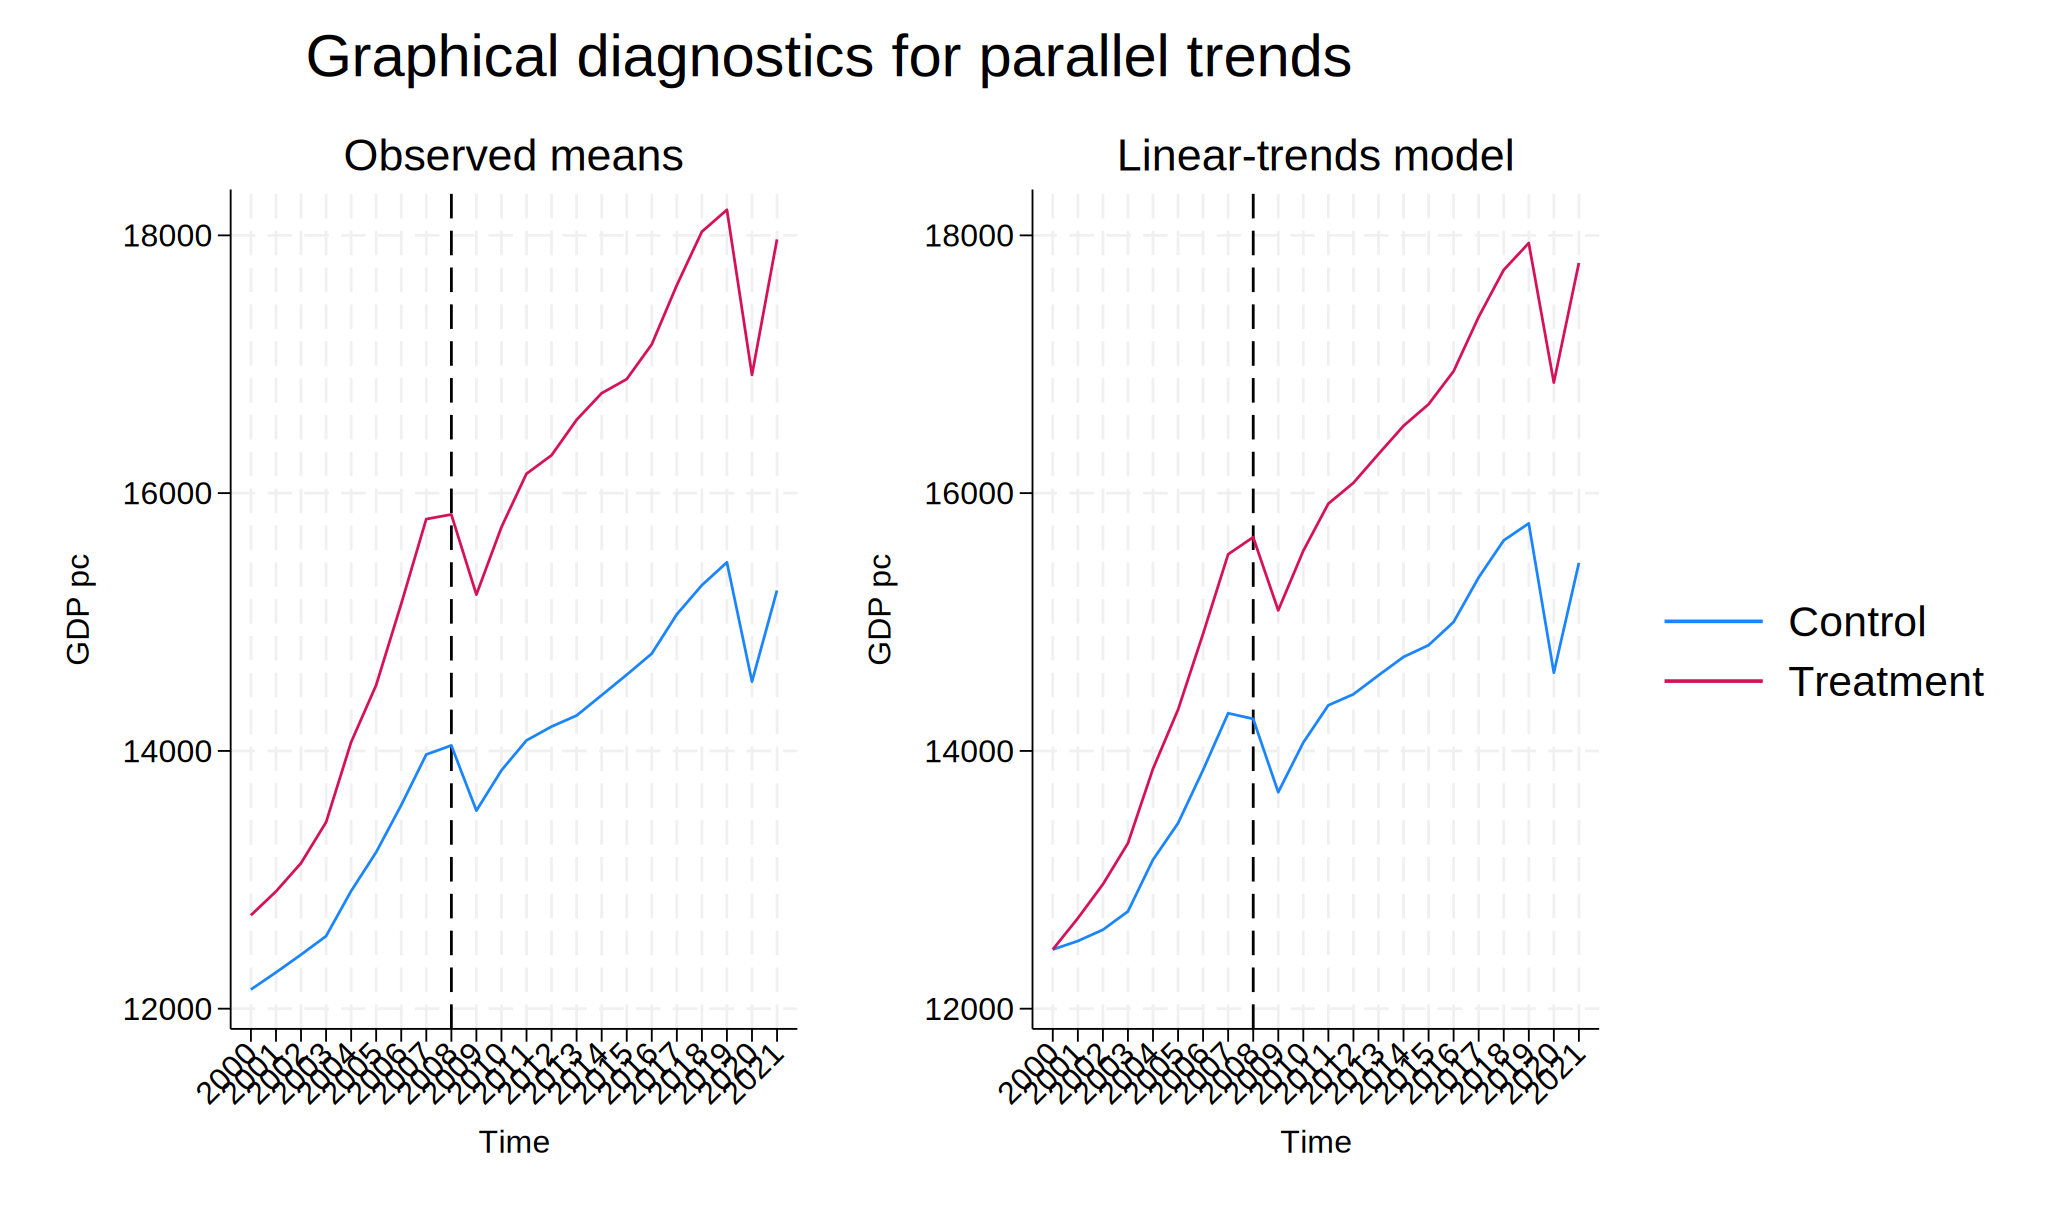

In [24]:
%%stata
xtdidregress (gdppc) (did), group(country1) time(year) 
estat trendplots, ytitle(GDP pc)

## 使用 OLS 固定效应回归（手动估计）

### 双重差分的基础回归：所有单位在同一时间经历事件

- 创建一个带标签的数值型变量，用作分组或面板变量

```stata
encode country, gen(country1)
```

- DID 回归中不需要单独包括 after 和 treated 变量，因为已包含面板和时间固定效应

在使用固定效应模型（如 `xtreg`, `fe` 或 `areg` 带 `absorb()`）进行差分中的差分回归时，只需要包含处理组与时间的交互项（即 `treated#after`），因为：

- 个体固定效应 已控制了处理组与对照组之间的时间不变差异；
- 时间固定效应 已控制了所有单位随时间的共同趋势。

```stata
xtreg gdppc did i.year, fe vce(cluster country1)
```

变量 `did` 的回归系数即为双重差分（DID）的估计量。该效应在 95% 显著性水平下不显著（P>|t| > 0.05），因此我们可以认为该事件对因变量没有显著影响。

### 可视化平行趋势

```stata
bysort year treated: egen mean_gdppc = mean(gdppc) 
twoway line mean_gdppc year if treated == 0, sort || /// 
line mean_gdppc year if treated == 1, sort lpattern(dash) /// 
legend(label(1 "Control") label(2 "Treated")) /// 
xline(2009)
```